In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip3 install torch torchvision pandas transformers scikit-learn tensorflow numpy seaborn matplotlib textwrap3 sentencepiece

In [ ]:
!ls gdrive/MyDrive/data_image

california_wildfires  hurricane_irma   iraq_iran_earthquake  srilanka_floods
hurricane_harvey      hurricane_maria  mexico_earthquake


In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
import transformers
from transformers import get_linear_schedule_with_warmup
from torchvision import transforms
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image

def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9_]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.,!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

def label_to_target(text):
  if text == "informative":
    return 1
  else:
    return 0

df_train = pd.read_csv("./gdrive/MyDrive/Models/train.tsv", sep='\t')
df_train = df_train[['image', 'label_text']]
df_train = df_train.sample(frac=1, random_state = 24).reset_index(drop=True)
df_train['label_text'] = df_train['label_text'].apply(label_to_target)

df_val = pd.read_csv("./gdrive/MyDrive/Models/val.tsv", sep='\t')
df_val = df_val[['image', 'label_text']]
df_val = df_val.sample(frac=1, random_state = 24).reset_index(drop=True)
df_val['label_text'] = df_val['label_text'].apply(label_to_target)

df_test = pd.read_csv("./gdrive/MyDrive/Models/test.tsv", sep='\t')
df_test = df_test[['image', 'label_text']]
df_test = df_test.sample(frac=1, random_state = 24).reset_index(drop=True)
df_test['label_text'] = df_test['label_text'].apply(label_to_target)


In [3]:
data_dir = "./gdrive/MyDrive/"
class DisasterTweetDataset(Dataset):

  def __init__(self, paths, targets):
    self.paths = paths
    self.targets = targets
    self.transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  
  def __len__(self):
    return len(self.paths)
  
  def __getitem__(self, item):
    path = str(self.paths[item])
    target = self.targets[item]

    img = Image.open(data_dir+self.paths[item]).convert('RGB')
    img = self.transform(img)  

    return {
      'tweet_image': img,
      'targets': torch.tensor(target, dtype=torch.long)
    }

def create_data_loader(df, batch_size):
  ds = DisasterTweetDataset(
    paths=df.image.to_numpy(),
    targets=df.label_text.to_numpy(),
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )


class TweetClassifier(nn.Module):

  def __init__(self):
    super(TweetClassifier, self).__init__()
    self.resnext = torchvision.models.resnext50_32x4d(pretrained=True)
    # for param in self.resnext.parameters():
    #   param.requires_grad = False

    self.linear1 = nn.Linear(1000, 256)
    self.relu    = nn.ReLU()
    self.dropout = nn.Dropout(p=0.4)
    self.linear2 = nn.Linear(256, 1)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, tweet_img):
    output = self.resnext(tweet_img)
    linear1_output = self.linear1(output)
    relu_output = self.relu(linear1_output)
    dropout_output = self.dropout(relu_output)
    linear2_output = self.linear2(dropout_output)
    probas = self.sigmoid(linear2_output)
    return probas


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    tweet_imgs = d["tweet_image"].to(device)
    targets = d["targets"].reshape(-1, 1).float()
    targets = targets.to(device)

    outputs = model(
      tweet_img = tweet_imgs
    )


    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(torch.round(outputs) == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      tweet_imgs = d["tweet_image"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(
        tweet_img = tweet_imgs
      )

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(torch.round(outputs) == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [4]:
BATCH_SIZE = 64

train_data_loader = create_data_loader(df_train, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, BATCH_SIZE)


model = TweetClassifier()
model = model.to(device)

EPOCHS = 40

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.BCELoss().to(device)

In [5]:
history = defaultdict(list)
start_epoch = 0
best_accuracy = -1

# checkpoint = torch.load("./gdrive/MyDrive/Models/ResNeXt/checkpoint.t7")
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch']

# print(start_epoch)
# print(checkpoint['best_accuracy'])


for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if 1:
    state = {
            'best_accuracy': val_acc,
            'epoch': start_epoch+epoch+1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
    }
    savepath= "./gdrive/MyDrive/Models/ResNeXt/checkpoint.t7"
    torch.save(state,savepath)
    best_accuracy = val_acc

Epoch 1/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.4191951837563357 accuracy 0.8098114779710447
Val   loss 0.359236336350441 accuracy 0.8493324856961221

Epoch 2/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.1921736423345591 accuracy 0.9289657327361733
Val   loss 0.45066380500793457 accuracy 0.8359821996185632

Epoch 3/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0682694675117139 accuracy 0.9825018227267993
Val   loss 0.6416543436050415 accuracy 0.8264462809917356

Epoch 4/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.037138835813415344 accuracy 0.9938548067909593
Val   loss 0.7340599846839905 accuracy 0.82453909726637

Epoch 5/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.027923815255554468 accuracy 0.9975002603895428
Val   loss 0.871400101184845 accuracy 0.8397965670692944

Epoch 6/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.014577438340309178 accuracy 0.9988542860118738
Val   loss 0.9097359067201615 accuracy 0.8423394787031151

Epoch 7/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.011197188455063699 accuracy 0.9989584418289761
Val   loss 1.0152589547634125 accuracy 0.8385251112523839

Epoch 8/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.010867652897484021 accuracy 0.9997916883657952
Val   loss 0.9237770628929138 accuracy 0.8334392879847425

Epoch 9/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0029685811565672193 accuracy 0.9998958441828976
Val   loss 1.081264226436615 accuracy 0.8353464717101081

Epoch 10/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0016101765123789395 accuracy 0.9996875325486928
Val   loss 1.1530718433856963 accuracy 0.8366179275270185

Epoch 11/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0016155607859730402 accuracy 0.9996875325486928
Val   loss 1.1515252208709716 accuracy 0.8328035600762873

Epoch 12/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0008486726875698336 accuracy 1.0
Val   loss 1.322331472635269 accuracy 0.8353464717101081

Epoch 13/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.00019171831731518556 accuracy 1.0
Val   loss 1.2253942358493806 accuracy 0.8359821996185632

Epoch 14/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0001558633830216615 accuracy 1.0
Val   loss 1.2222156250476837 accuracy 0.8340750158931978

Epoch 15/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0002412728363257179 accuracy 1.0
Val   loss 1.4408791196346282 accuracy 0.8321678321678322

Epoch 16/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0004105487722887685 accuracy 0.9997916883657952
Val   loss 1.4543666851520538 accuracy 0.8302606484424666

Epoch 17/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.00034220091248358427 accuracy 0.9998958441828976
Val   loss 1.6246296095848083 accuracy 0.8353464717101081

Epoch 18/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0005097452160091944 accuracy 0.9998958441828976
Val   loss 1.6995680546760559 accuracy 0.8308963763509218

Epoch 19/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0003192464777902875 accuracy 0.9998958441828976
Val   loss 1.652351529598236 accuracy 0.8340750158931978

Epoch 20/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.00021645112837183317 accuracy 1.0
Val   loss 1.8534871554374694 accuracy 0.8340750158931978

Epoch 21/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.00037781898668945603 accuracy 1.0
Val   loss 1.9257119250297547 accuracy 0.8347107438016529

Epoch 22/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.000894738485661019 accuracy 0.9998958441828976
Val   loss 1.5858740949630736 accuracy 0.8328035600762873

Epoch 23/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.00033340536051492255 accuracy 0.9997916883657952
Val   loss 1.6883894443511962 accuracy 0.8296249205340115

Epoch 24/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.002545353688413867 accuracy 0.9997916883657952
Val   loss 1.6300993585586547 accuracy 0.8302606484424666

Epoch 25/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.392917354544933e-05 accuracy 1.0
Val   loss 1.6351622939109802 accuracy 0.8308963763509218

Epoch 26/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.371419522462586e-05 accuracy 1.0
Val   loss 1.7874820816516876 accuracy 0.8302606484424666

Epoch 27/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.6428357604964303e-05 accuracy 1.0
Val   loss 1.8466280317306518 accuracy 0.8302606484424666

Epoch 28/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 9.765402140731006e-06 accuracy 1.0
Val   loss 1.8529631471633912 accuracy 0.8308963763509218

Epoch 29/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.5127550953728988e-05 accuracy 1.0
Val   loss 1.8590006375312804 accuracy 0.8321678321678322

Epoch 30/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.559964730118218e-05 accuracy 1.0
Val   loss 1.8673259246349334 accuracy 0.8321678321678322

Epoch 31/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.3022846449241223e-05 accuracy 1.0
Val   loss 1.873494449853897 accuracy 0.8328035600762873

Epoch 32/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 7.588559036029263e-06 accuracy 1.0
Val   loss 1.8778550255298614 accuracy 0.8328035600762873

Epoch 33/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 8.51094330300839e-06 accuracy 1.0
Val   loss 1.8811913847923278 accuracy 0.8328035600762873

Epoch 34/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 8.676504003745244e-06 accuracy 1.0
Val   loss 1.9372424674034119 accuracy 0.8328035600762873

Epoch 35/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 9.579629710250274e-06 accuracy 1.0
Val   loss 1.9402770948410035 accuracy 0.8328035600762873

Epoch 36/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.248575978663645e-05 accuracy 1.0
Val   loss 1.9434295392036438 accuracy 0.8328035600762873

Epoch 37/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.5149511530732664e-05 accuracy 1.0
Val   loss 1.9467819154262542 accuracy 0.8328035600762873

Epoch 38/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 9.382020926368087e-06 accuracy 1.0
Val   loss 1.949891300201416 accuracy 0.8321678321678322

Epoch 39/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 5.536652491968355e-06 accuracy 1.0
Val   loss 1.9513762080669403 accuracy 0.8321678321678322

Epoch 40/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 8.539467151404217e-06 accuracy 1.0
Val   loss 1.9516688251495362 accuracy 0.8321678321678322



In [ ]:
state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/Models/ResNeXt/checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

NameError: ignored

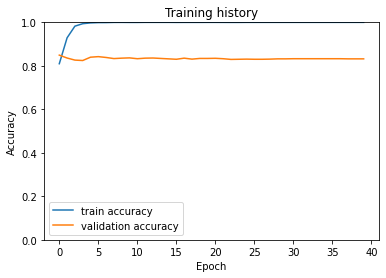

In [6]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [7]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      tweet_imgs = d["tweet_image"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(tweet_img=tweet_imgs)
      preds = torch.round(outputs)


      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=['Not Informative', 'Informative']))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


                 precision    recall  f1-score   support

Not Informative       0.79      0.75      0.77       504
    Informative       0.88      0.90      0.89      1030

       accuracy                           0.85      1534
      macro avg       0.83      0.82      0.83      1534
   weighted avg       0.85      0.85      0.85      1534

